# 🌍 EuroSAT Multispectral Dataset: A Deep Dive

## Notebook Overview

Welcome! This notebook provides a comprehensive visual and statistical exploration of the **EuroSAT multispectral (MS) dataset**. The EuroSAT dataset contains satellite images from Sentinel-2, which captures light across 13 different spectral bands—many of which are beyond what the human eye can see.

Our goal is to understand the unique **spectral signature** (like a spectral fingerprint) for each land cover class. We will do this by visualizing images and analyzing their underlying data.

--- 

### What You'll Learn:

1.  **✔️ Dataset Validation**: We'll start by checking the dataset's structure and counting the number of images in each land cover category.
2.  **🎨 Image Visualization**: We will look at sample images from each class in two ways:
    * **True Color (RGB)**: How we would naturally see it.
    * **Spectral Index**: A calculated view (like NDVI) that highlights specific features, such as vegetation health or water content.
3.  **📈 Statistical Analysis**: We will process thousands of images to calculate the average reflectance for each of the 13 spectral bands, revealing the unique signature of each class.
4.  **🔍 Signature Plotting**: Finally, we'll plot these signatures on a graph and a heatmap for easy comparison.

## ⚙️ Step 1: Setup and Environment Configuration

This first step is crucial. We will import all the necessary Python libraries for data handling, image processing, and visualization. We also configure the path to the dataset and perform a quick validation to make sure everything is in place before we begin our analysis.

🚀 Starting EuroSAT Dataset Overview at 2025-09-23 19:11:38
✅ Dataset folder found: T:\DEPI final Project\EuroSAT_MS
✅ Found 10 land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake

📊 Dataset Composition (Image Count per Class):
  ✅ AnnualCrop           : 2,000 images
  ✅ Forest               : 2,000 images
  ✅ HerbaceousVegetation : 2,000 images
  ✅ Highway              : 2,000 images
  ✅ Industrial           : 2,000 images
  ✅ Pasture              : 2,000 images
  ✅ PermanentCrop        : 2,000 images
  ✅ Residential          : 2,000 images
  ✅ River                : 2,000 images
  ✅ SeaLake              : 2,000 images

✨ Setup completed successfully! Ready for multi-class analysis.


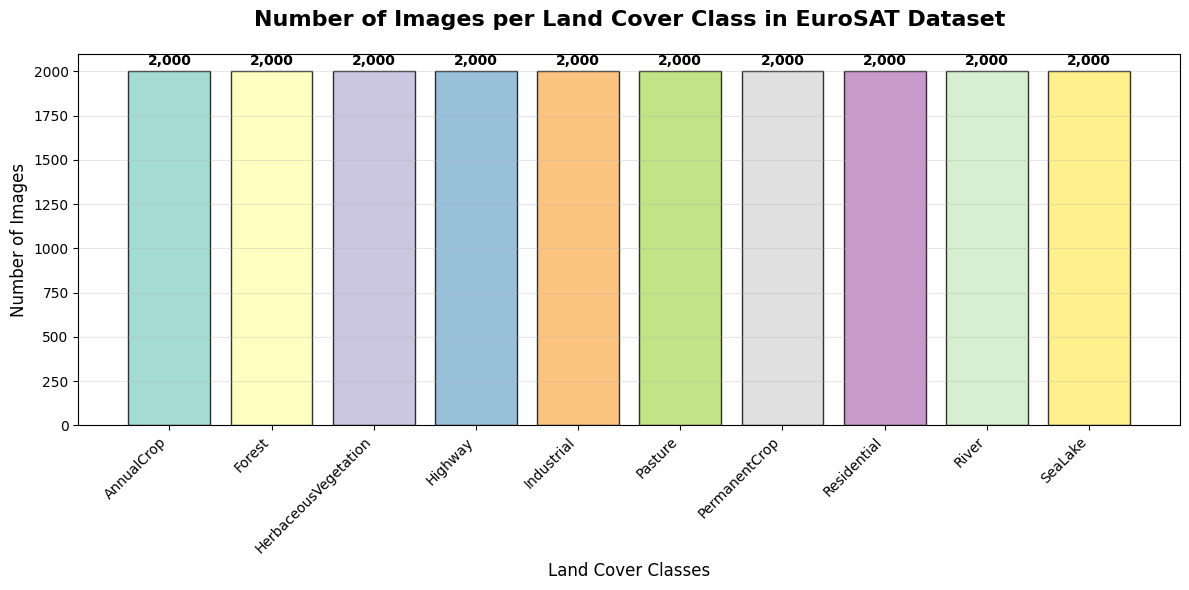

In [10]:
# ====== STEP 1: Dataset Setup and Validation ======
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import rasterio
from datetime import datetime

# Set a consistent style for visualizations
plt.style.use('default')
sns.set_palette("husl")

# --- Path Configuration ---
# IMPORTANT: Update DATA_DIR with the correct path to your EuroSAT_MS folder
DATA_DIR = Path(r"T:\DEPI final Project\EuroSAT_MS")

print(f"🚀 Starting EuroSAT Dataset Overview at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 65)

# --- Data Validation ---
if not DATA_DIR.exists():
    raise FileNotFoundError(f"❌ ERROR: Dataset folder not found at: {DATA_DIR}\n"
                        f"Please update DATA_DIR with the correct path to your EuroSAT_MS folder.")
print(f"✅ Dataset folder found: {DATA_DIR}")

# Get a sorted list of all class names (which are the directory names)
classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
if not classes:
    raise FileNotFoundError(f"❌ ERROR: No class folders found inside {DATA_DIR}\n"
                        f"Expected folders like 'AnnualCrop', 'River', etc.")
print(f"✅ Found {len(classes)} land cover classes: {', '.join(classes)}")

# --- Dataset Overview ---
# Count the number of '.tif' images in each class folder.
print("\n📊 Dataset Composition (Image Count per Class):")
counts = {}
for c in classes:
    count = len(list((DATA_DIR / c).glob("*.tif")))
    counts[c] = count
    status = "✅" if count > 0 else "⚠️"
    print(f"  {status} {c:<20} : {count:,} images")

print("\n✨ Setup completed successfully! Ready for multi-class analysis.")

# --- Visualize Dataset Distribution ---
plt.figure(figsize=(12, 6))
classes_sorted = sorted(counts.keys(), key=lambda x: counts[x], reverse=True)
values = [counts[c] for c in classes_sorted]
colors = plt.cm.Set3(np.linspace(0, 1, len(classes_sorted)))

bars = plt.bar(classes_sorted, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.title('Number of Images per Land Cover Class in EuroSAT Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Land Cover Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Visualizing Class Distribution

Now, let's create a bar chart to visualize how many images we have for each class. This helps us see if the dataset is **balanced** (i.e., has a similar number of images for each class).

### 📊 Figure: EuroSAT Dataset Distribution by Land Cover Class
This colorful bar chart is like a library catalog that shows us how many satellite images we have for each type of land cover in our EuroSAT dataset! Think of it like different sections in a library - each bar represents a different category of land (like forests, cities, water, farms, etc.).

What's really great about this chart is that it shows we have exactly 2,000 images for each type of land cover. This means our dataset is perfectly balanced - like having the same number of books in each section of the library. This is super important because it helps our computer learn equally well about all different types of land, not just one type.

Each bar is a different color to make it easy to tell them apart:
- **AnnualCrop & PermanentCrop**: These are farm fields where crops are grown
- **Forest**: Areas covered with trees
- **HerbaceousVegetation**: Grasslands and natural meadows
- **Highway**: Major roads and transportation networks
- **Industrial**: Factories, warehouses, and industrial areas
- **Pasture**: Fields where animals graze
- **Residential**: Houses, neighborhoods, and urban areas
- **River & SeaLake**: Different types of water bodies

This balanced dataset is perfect for training computers to recognize different types of land from space images!

## 🎨 Step 2: Comparative Image Visualization

Seeing is believing! In this step, we'll visually inspect sample images from each class. For each image, we'll show two views:

1.  **True Color (RGB)**: This is a composite of the Red (B4), Green (B3), and Blue (B2) bands, representing what our eyes would see.
2.  **Spectral Index**: This is a calculation using different spectral bands to highlight certain features.
    * **NDVI (Normalized Difference Vegetation Index)**: Excellent for identifying healthy vegetation. It uses the Red and Near-Infrared (NIR) bands. High values (green) mean healthy plants.
    * **NDWI (Normalized Difference Water Index)**: Ideal for spotting water bodies. It uses the Green and NIR bands. High values (blue) indicate water.

In [11]:
# ====== STEP 2.1: Helper Functions for Visualization ======

def enhanced_stretch(x, percentiles=(2, 98), gamma=1.0):
    """
    Applies a contrast stretch to image data for better visualization.
    
    This function takes an image array, finds the 2nd and 98th percentile values, 
    and stretches this range to the full 0-1 display range, clipping outliers.
    This makes images appear less washed out or dark.
    """
    x = x.astype(np.float32)
    # Use only valid (non-zero) pixels to calculate percentiles
    valid_pixels = x[x > 0]
    if valid_pixels.size == 0:
        return np.zeros_like(x) # Return a black image if no valid pixels
        
    # Calculate the percentile values
    lo, hi = np.percentile(valid_pixels, percentiles)
    
    # Stretch the data and clip it to a 0-1 range
    stretched = np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)
    
    # Apply gamma correction to adjust brightness
    return np.power(stretched, 1/gamma)

def get_relevant_index(class_name):
    """
    Selects the most appropriate spectral index and color map for a given class.
    For vegetation, we use NDVI. For water, we use NDWI.
    """
    if class_name in ['AnnualCrop', 'PermanentCrop', 'Forest', 'HerbaceousVegetation', 'Pasture']:
        return 'NDVI', 'RdYlGn' # Red-Yellow-Green colormap is intuitive for vegetation
    elif class_name in ['River', 'SeaLake']:
        return 'NDWI', 'Blues' # Shades of blue for water
    else: # For classes like buildings or highways
        return 'NDVI', 'viridis' # Viridis is a good general-purpose colormap

def calculate_index(band_cache, index_name):
    """
    Calculates NDVI or NDWI from a cache of Sentinel-2 bands.
    The formulas are:
    - NDVI = (NIR - Red) / (NIR + Red)
    - NDWI = (Green - NIR) / (Green + NIR)
    """
    # Add a small epsilon (1e-6) to the denominator to prevent division by zero
    if index_name == 'NDVI':
        nir_band = band_cache[8].astype(np.float32)
        red_band = band_cache[4].astype(np.float32)
        denominator = nir_band + red_band
        index = np.divide(nir_band - red_band, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    elif index_name == 'NDWI':
        green_band = band_cache[3].astype(np.float32)
        nir_band = band_cache[8].astype(np.float32)
        denominator = green_band + nir_band
        index = np.divide(green_band - nir_band, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    else:
        # Return an empty array if the index is not recognized
        return np.zeros_like(band_cache[1])
        
    # The index value should always be between -1 and 1
    return np.clip(index, -1, 1)


==================== AnnualCrop ====================



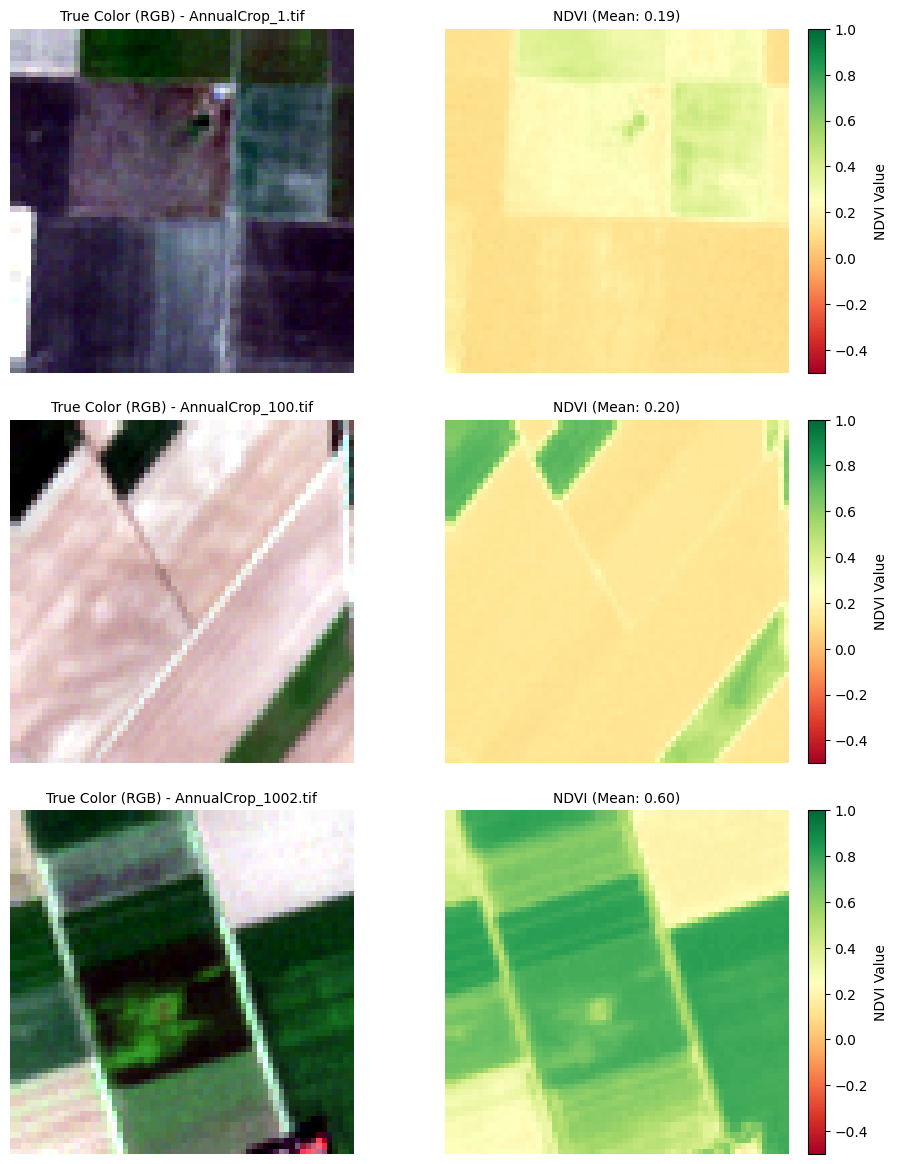

### 📊 Statistics for class: AnnualCrop

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| AnnualCrop_1.tif | NDVI | 0.1888 | 1323.2026 | 1124.5146 | 1044.7319 | 1169.2815 | 1291.6272 | 1553.7549 | 1765.6694 | 1748.9553 | 484.0559 | 11.5698 | 2715.3987 | 1980.8850 | 2030.5452 |
| AnnualCrop_100.tif | NDVI | 0.2018 | 1613.5339 | 1543.5591 | 1612.5850 | 1922.6953 | 2114.6797 | 2631.8557 | 3002.1934 | 2893.6104 | 700.9436 | 15.1304 | 3569.5525 | 2664.0051 | 3337.2512 |
| AnnualCrop_1002.tif | NDVI | 0.6000 | 1342.1221 | 1068.4028 | 1022.6345 | 738.6772 | 1133.7117 | 2802.3892 | 3459.8354 | 3225.8403 | 739.1987 | 8.1018 | 1568.4683 | 867.0156 | 3663.5452 |


==================== Forest ====================



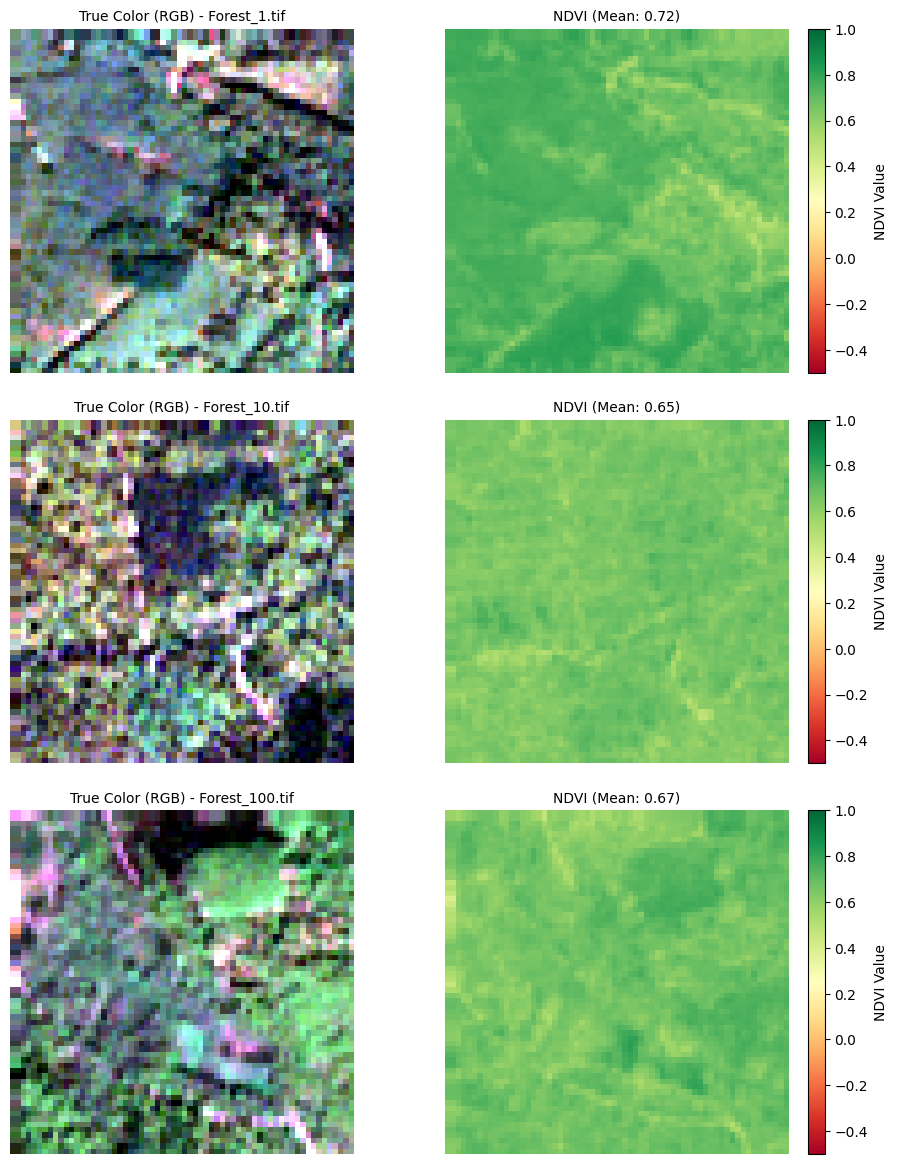

### 📊 Statistics for class: Forest

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| Forest_1.tif | NDVI | 0.7180 | 1149.4785 | 831.3069 | 652.2683 | 410.1682 | 659.0276 | 1998.1006 | 2707.4451 | 2612.3589 | 579.3015 | 8.4480 | 1304.6868 | 496.3159 | 3114.8657 |
| Forest_10.tif | NDVI | 0.6520 | 1165.4583 | 883.6467 | 715.9233 | 481.4382 | 735.4443 | 1818.1411 | 2383.6523 | 2312.3257 | 467.3000 | 8.8899 | 1270.2603 | 513.7808 | 2743.5403 |
| Forest_100.tif | NDVI | 0.6698 | 1098.4512 | 819.1855 | 787.0876 | 478.3000 | 1041.5559 | 2122.9016 | 2461.0449 | 2477.7444 | 1241.7478 | 6.4075 | 1418.9854 | 709.5037 | 2757.9702 |


==================== HerbaceousVegetation ====================



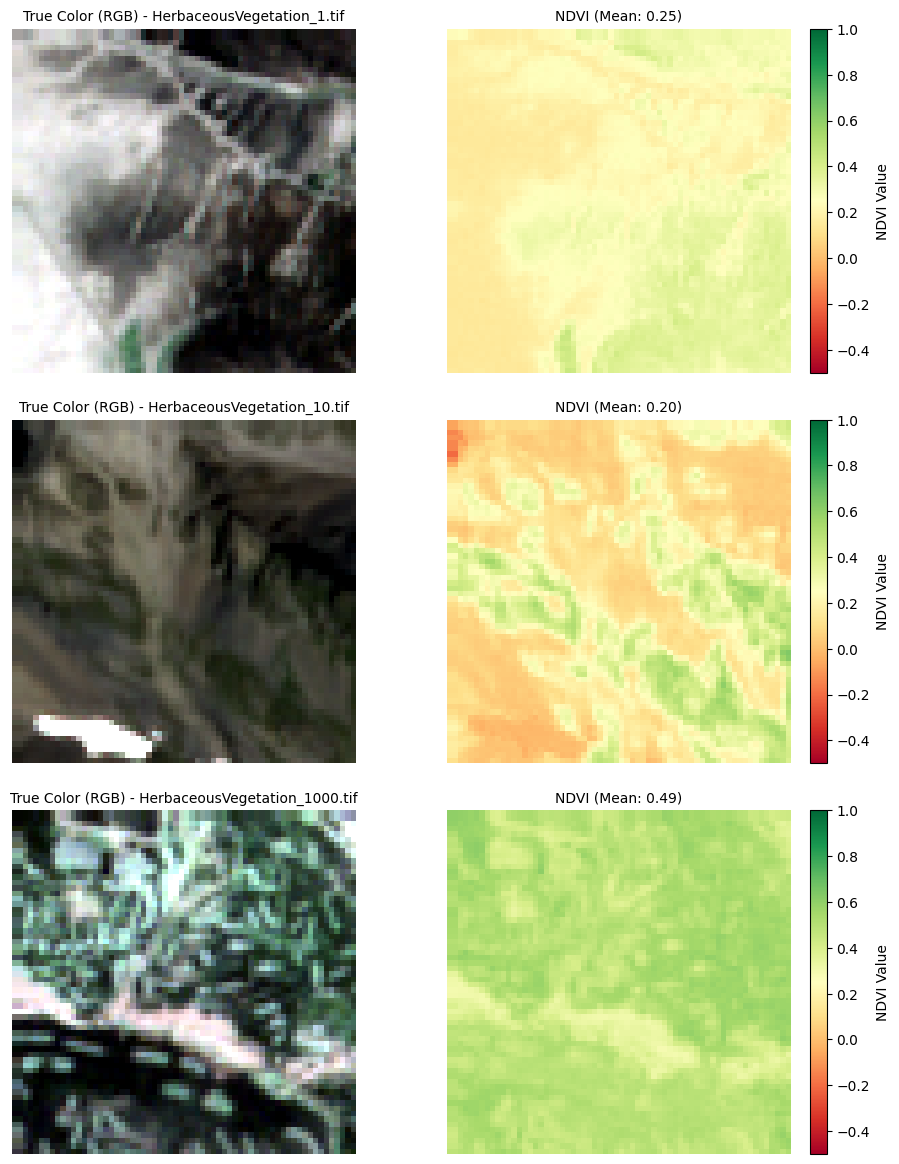

### 📊 Statistics for class: HerbaceousVegetation

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| HerbaceousVegetation_1.tif | NDVI | 0.2477 | 1329.0022 | 1165.9678 | 1079.8721 | 1314.0332 | 1548.2803 | 1830.2939 | 2055.8762 | 2121.2595 | 1078.0156 | 17.8425 | 2791.4185 | 1796.8164 | 2369.1201 |
| HerbaceousVegetation_10.tif | NDVI | 0.1951 | 1343.5337 | 1295.2747 | 1345.5232 | 1386.7070 | 1601.6511 | 1947.0339 | 2078.7527 | 2064.2144 | 1259.7673 | 36.0083 | 2515.3831 | 1933.9768 | 2188.1433 |
| HerbaceousVegetation_1000.tif | NDVI | 0.4857 | 1095.1550 | 840.1609 | 688.2473 | 661.7207 | 981.5535 | 1518.7351 | 1769.0186 | 1881.7314 | 1073.9683 | 15.4883 | 1935.9958 | 1040.3894 | 2116.8569 |


==================== Highway ====================



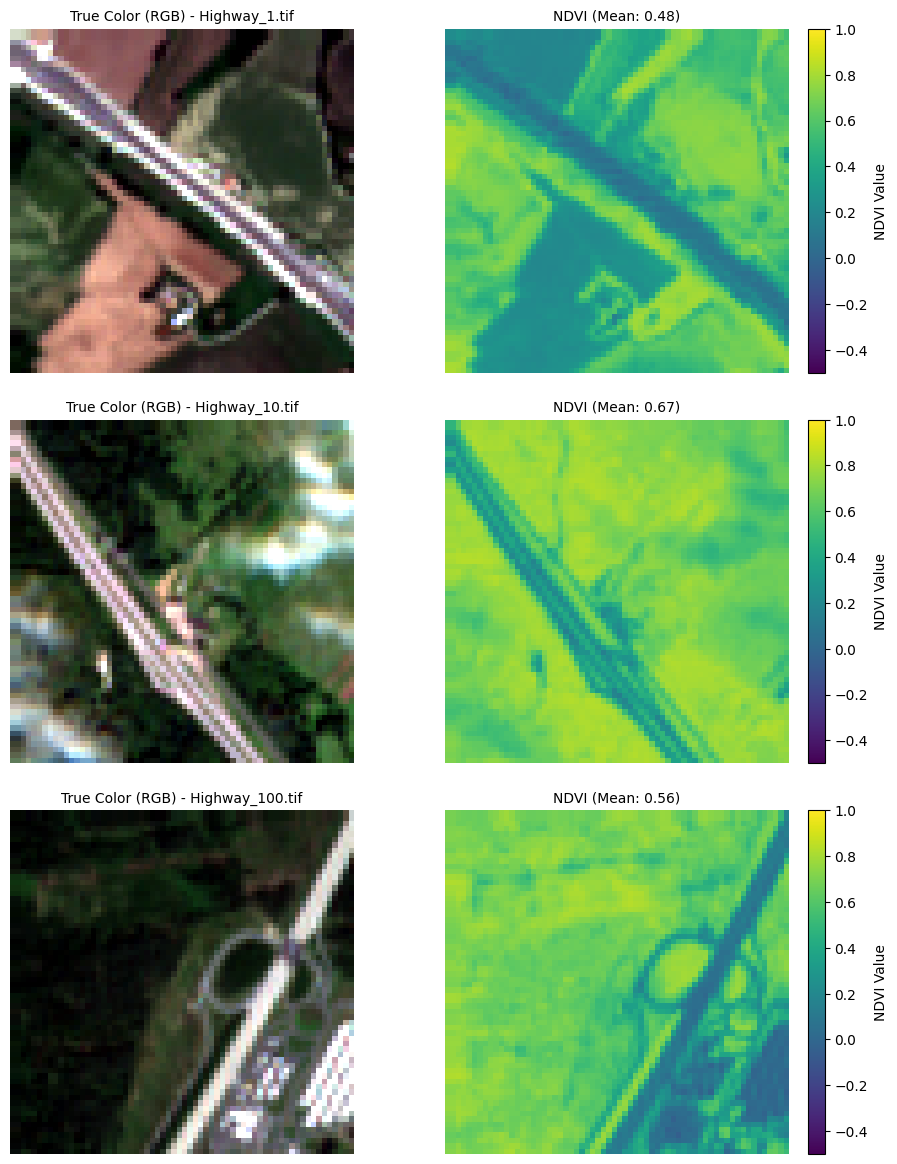

### 📊 Statistics for class: Highway

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| Highway_1.tif | NDVI | 0.4754 | 1369.3538 | 1222.2253 | 1282.8047 | 1250.8472 | 1671.1558 | 3008.0266 | 3558.1531 | 3525.5427 | 1362.3618 | 13.9336 | 2599.7590 | 1524.1460 | 3859.2170 |
| Highway_10.tif | NDVI | 0.6651 | 1243.7898 | 964.9409 | 891.8855 | 634.4885 | 1058.0159 | 2658.2607 | 3257.3696 | 3218.5432 | 1056.2515 | 13.0747 | 1785.8452 | 874.0906 | 3669.7466 |
| Highway_100.tif | NDVI | 0.5587 | 1195.7710 | 965.8164 | 891.1106 | 701.5432 | 987.6548 | 2037.5979 | 2452.4175 | 2366.5425 | 677.6501 | 9.4514 | 1492.5959 | 804.7239 | 2664.8181 |


==================== Industrial ====================



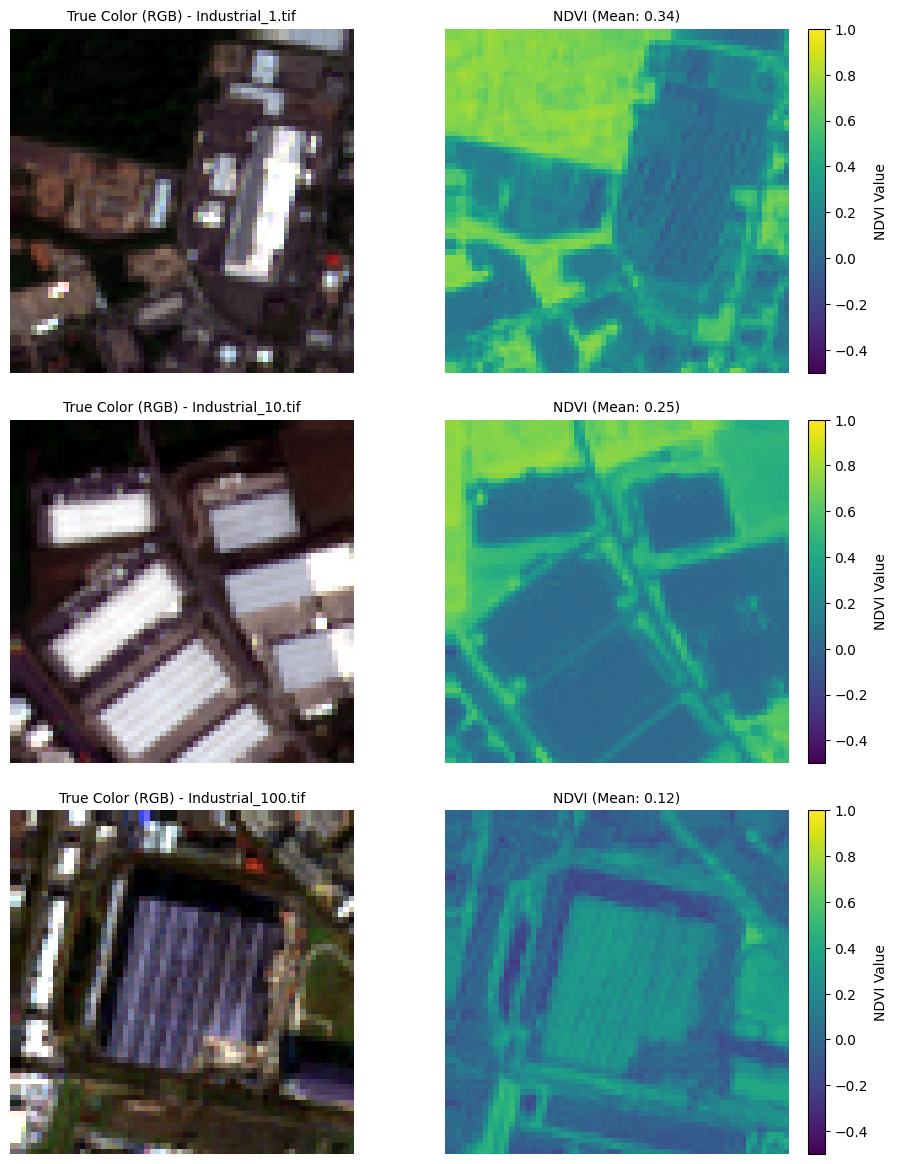

### 📊 Statistics for class: Industrial

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| Industrial_1.tif | NDVI | 0.3371 | 1513.5686 | 1353.5510 | 1331.4558 | 1307.3955 | 1566.8250 | 2306.9512 | 2568.0291 | 2504.6060 | 958.7681 | 12.0593 | 2010.8005 | 1391.5964 | 2722.3774 |
| Industrial_10.tif | NDVI | 0.2545 | 1798.4929 | 1689.4744 | 1723.6155 | 1669.0037 | 1818.9485 | 2526.2869 | 2820.0986 | 2681.8054 | 654.1306 | 12.1299 | 2155.4597 | 1442.0762 | 2993.3835 |
| Industrial_100.tif | NDVI | 0.1180 | 1910.6433 | 1517.9832 | 1097.7263 | 960.0706 | 997.9055 | 1122.0627 | 1251.6858 | 1273.2690 | 487.7788 | 12.7283 | 1261.5813 | 942.7222 | 1440.3550 |


==================== Pasture ====================



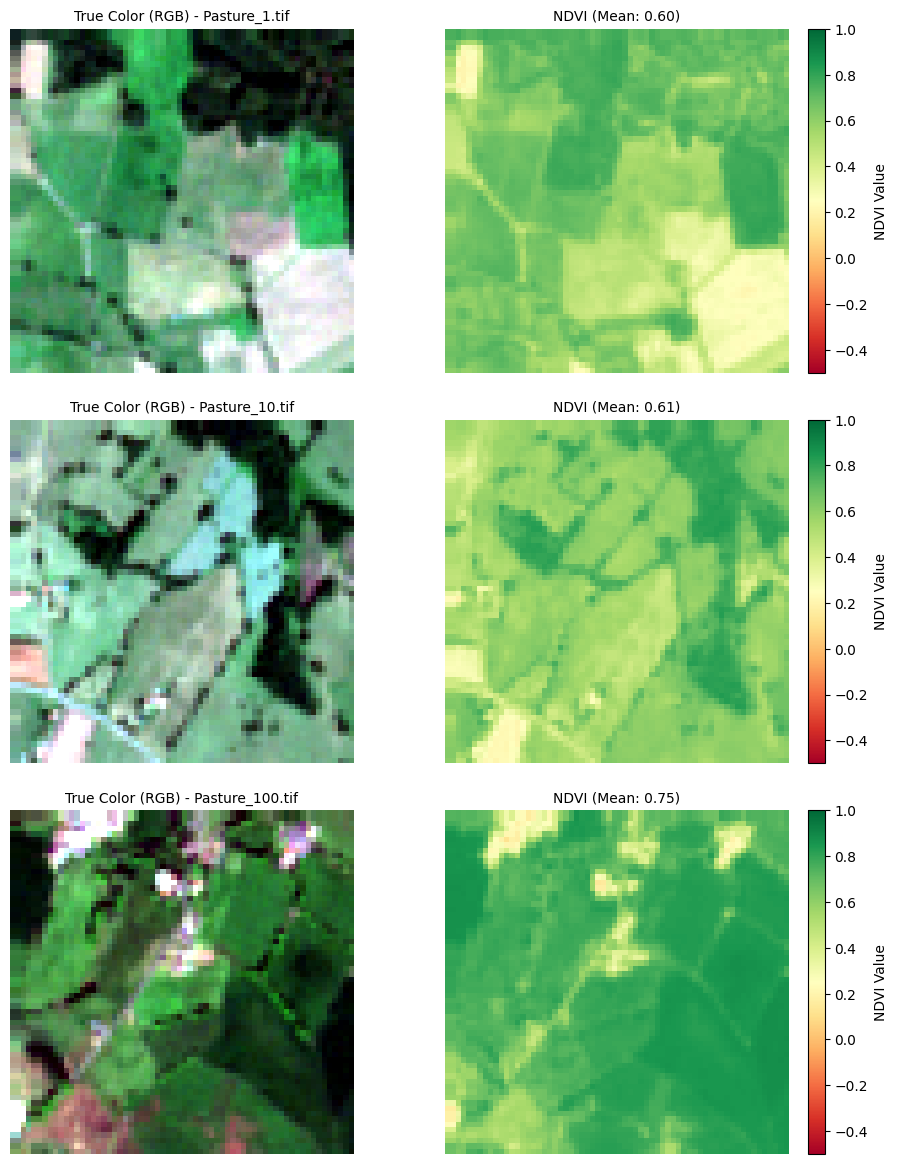

### 📊 Statistics for class: Pasture

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| Pasture_1.tif | NDVI | 0.5996 | 1228.6973 | 953.4045 | 872.2346 | 661.9424 | 1026.5352 | 2313.6140 | 2881.3323 | 2742.2710 | 585.1287 | 10.2688 | 2038.9812 | 990.5583 | 3251.7317 |
| Pasture_10.tif | NDVI | 0.6092 | 1135.7639 | 927.0413 | 943.1948 | 774.4954 | 1279.5603 | 2621.8159 | 3206.4834 | 3197.1926 | 1003.3838 | 11.3708 | 2465.5344 | 1261.9148 | 3641.7646 |
| Pasture_100.tif | NDVI | 0.7477 | 1120.3914 | 872.1487 | 869.1511 | 538.7615 | 1142.0642 | 3187.2490 | 4007.6101 | 4018.1355 | 1706.4021 | 14.5752 | 1821.3479 | 835.9636 | 4405.7742 |


==================== PermanentCrop ====================



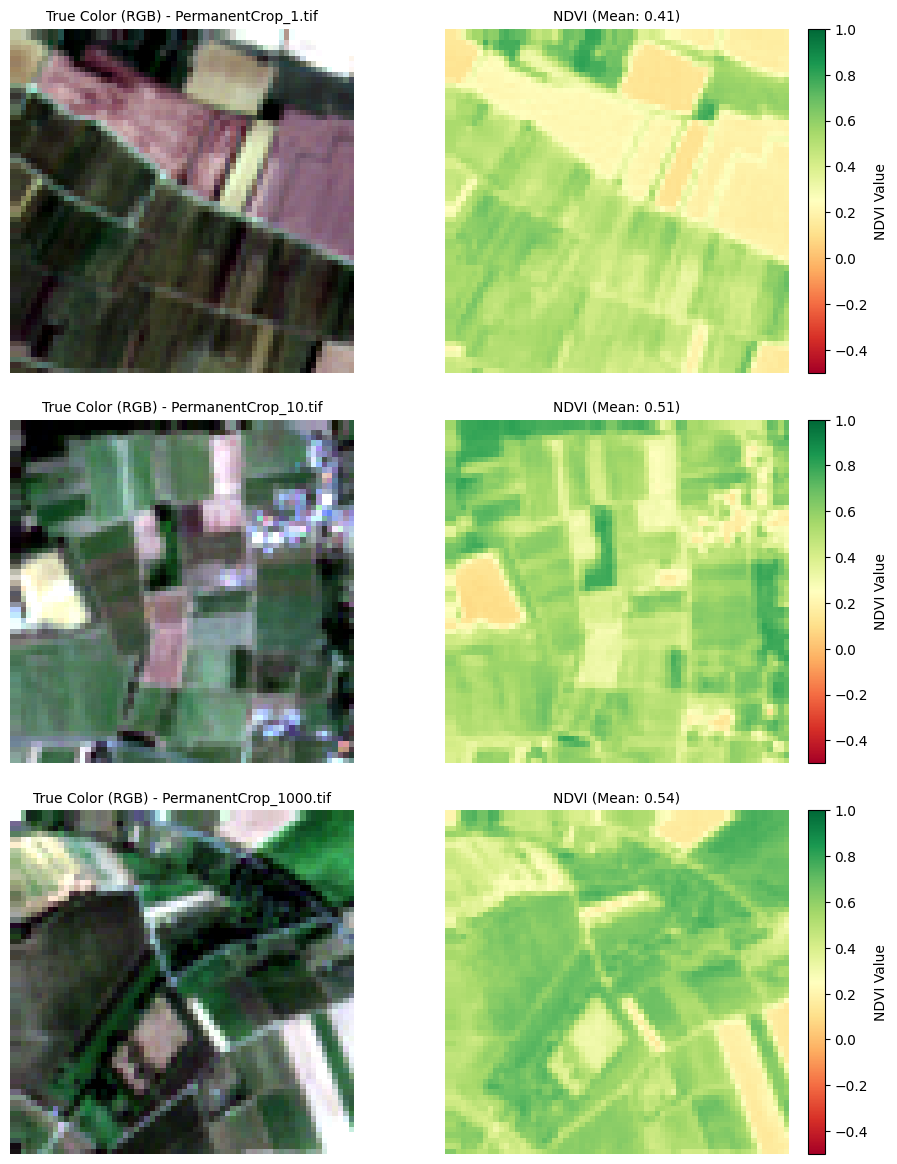

### 📊 Statistics for class: PermanentCrop

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| PermanentCrop_1.tif | NDVI | 0.4082 | 1236.5637 | 1056.5740 | 1152.2122 | 1208.2175 | 1586.3435 | 2481.2571 | 2902.6296 | 2823.4055 | 857.0293 | 10.6128 | 2605.6968 | 1570.7529 | 3234.6670 |
| PermanentCrop_10.tif | NDVI | 0.5100 | 1284.7852 | 1038.6123 | 1047.2527 | 954.8972 | 1414.8142 | 2516.3342 | 2984.6541 | 2938.3330 | 977.9121 | 12.3423 | 2518.2214 | 1416.4253 | 3359.4788 |
| PermanentCrop_1000.tif | NDVI | 0.5407 | 1330.7224 | 1074.2095 | 996.6484 | 834.9253 | 1182.7769 | 2398.4429 | 2947.5515 | 2819.8611 | 508.7568 | 10.4373 | 2099.8508 | 1085.7515 | 3314.6587 |


==================== Residential ====================



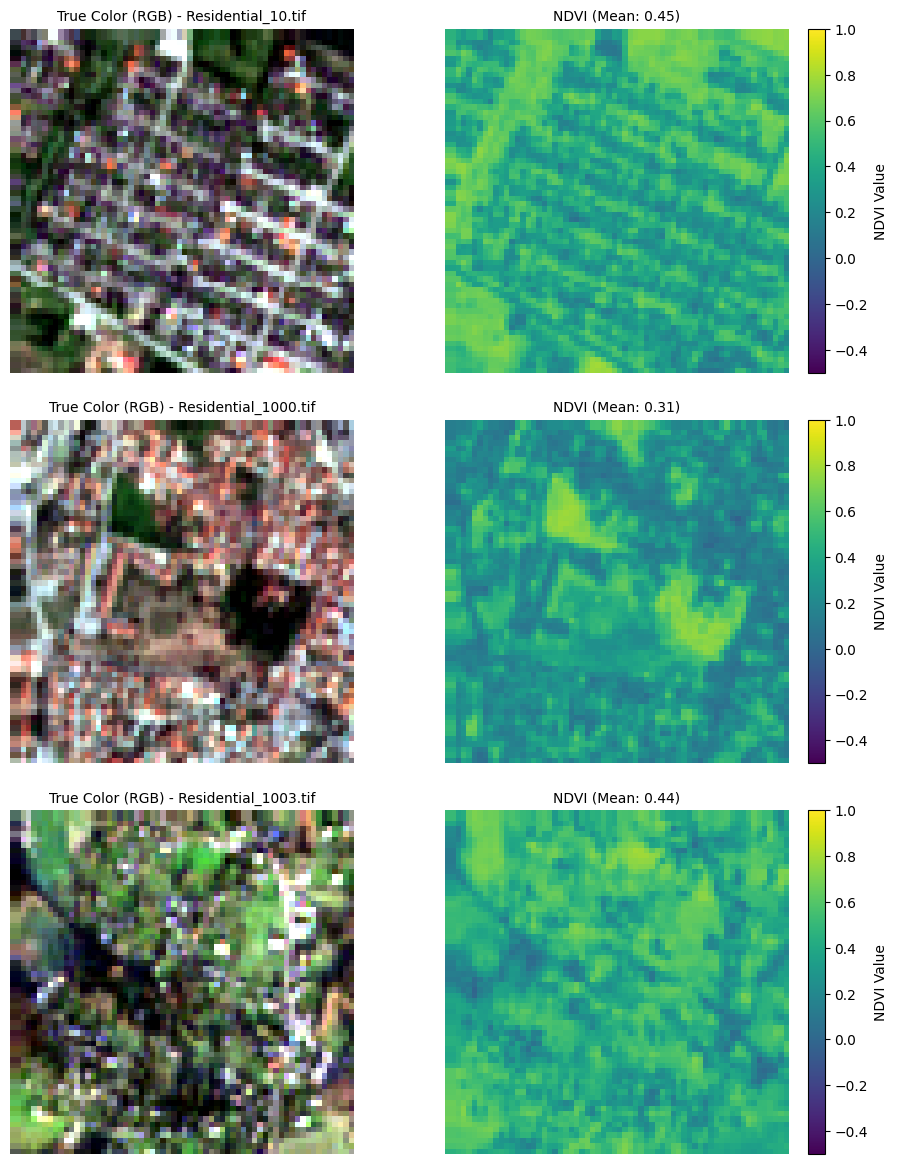

### 📊 Statistics for class: Residential

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| Residential_10.tif | NDVI | 0.4451 | 1383.5823 | 1106.8367 | 1003.3301 | 862.7827 | 1203.9961 | 2055.5022 | 2383.7419 | 2332.6025 | 907.2720 | 13.5146 | 1868.6599 | 1208.9548 | 2622.4233 |
| Residential_1000.tif | NDVI | 0.3114 | 1256.2698 | 1065.6841 | 991.9299 | 1042.7068 | 1206.1160 | 1788.9578 | 2080.6982 | 1990.4773 | 503.4434 | 11.1318 | 2186.9231 | 1587.4102 | 2252.5593 |
| Residential_1003.tif | NDVI | 0.4419 | 1572.9675 | 1187.6653 | 891.0046 | 649.4475 | 888.3264 | 1555.9265 | 1789.8699 | 1832.3899 | 969.3396 | 15.0825 | 1136.3809 | 665.4019 | 2003.7971 |


==================== River ====================



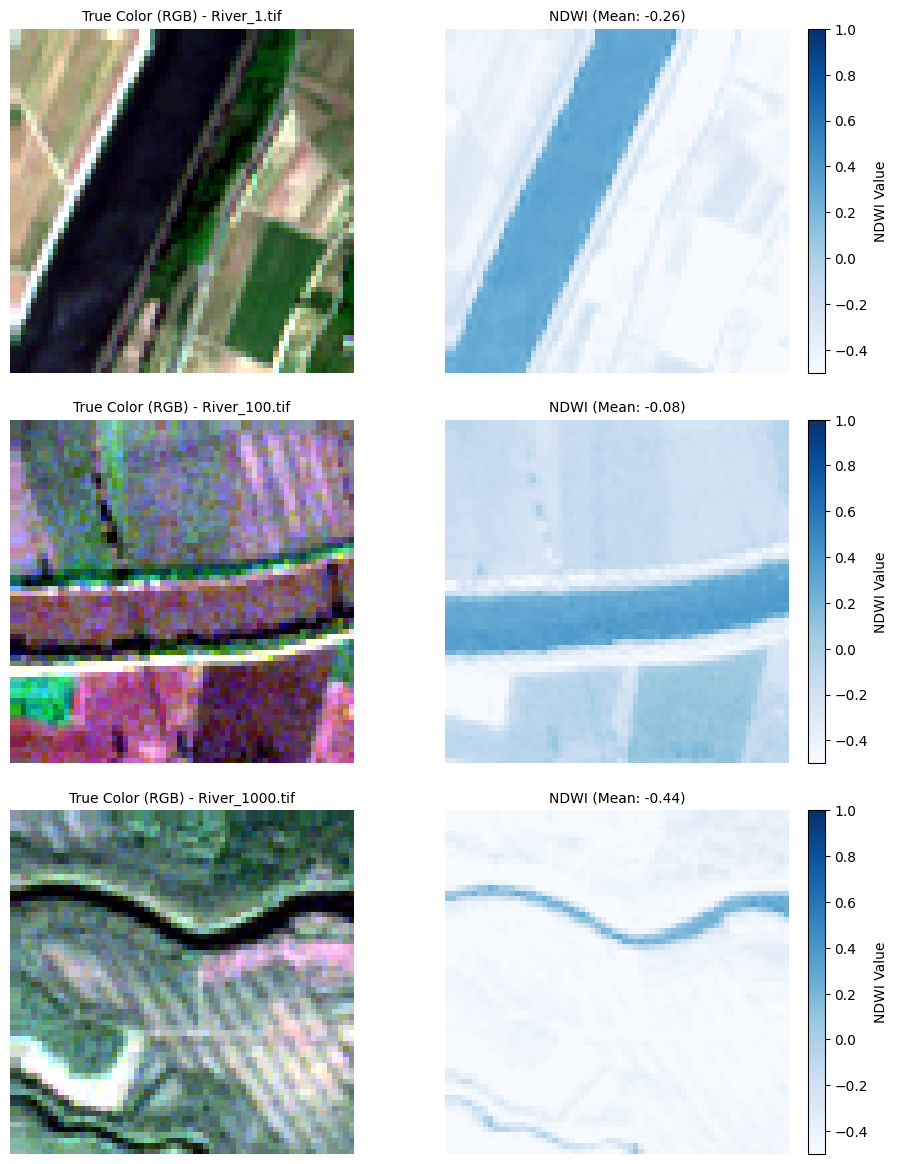

### 📊 Statistics for class: River

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| River_1.tif | NDWI | -0.2562 | 1189.9763 | 969.9980 | 919.3757 | 776.1240 | 1080.7214 | 1811.5652 | 2069.4939 | 2024.3643 | 826.1973 | 11.9680 | 1524.1423 | 983.0950 | 2219.8896 |
| River_100.tif | NDWI | -0.0838 | 1928.0576 | 1453.2888 | 1055.6494 | 872.8203 | 1025.7795 | 1387.0532 | 1498.3477 | 1404.8381 | 468.3279 | 16.7458 | 963.2007 | 561.2561 | 1561.8469 |
| River_1000.tif | NDWI | -0.4407 | 1162.8677 | 820.9126 | 642.3606 | 404.4812 | 665.8042 | 1514.7935 | 1820.9602 | 1765.5962 | 478.5312 | 8.6558 | 954.4045 | 416.2524 | 2067.1768 |


==================== SeaLake ====================



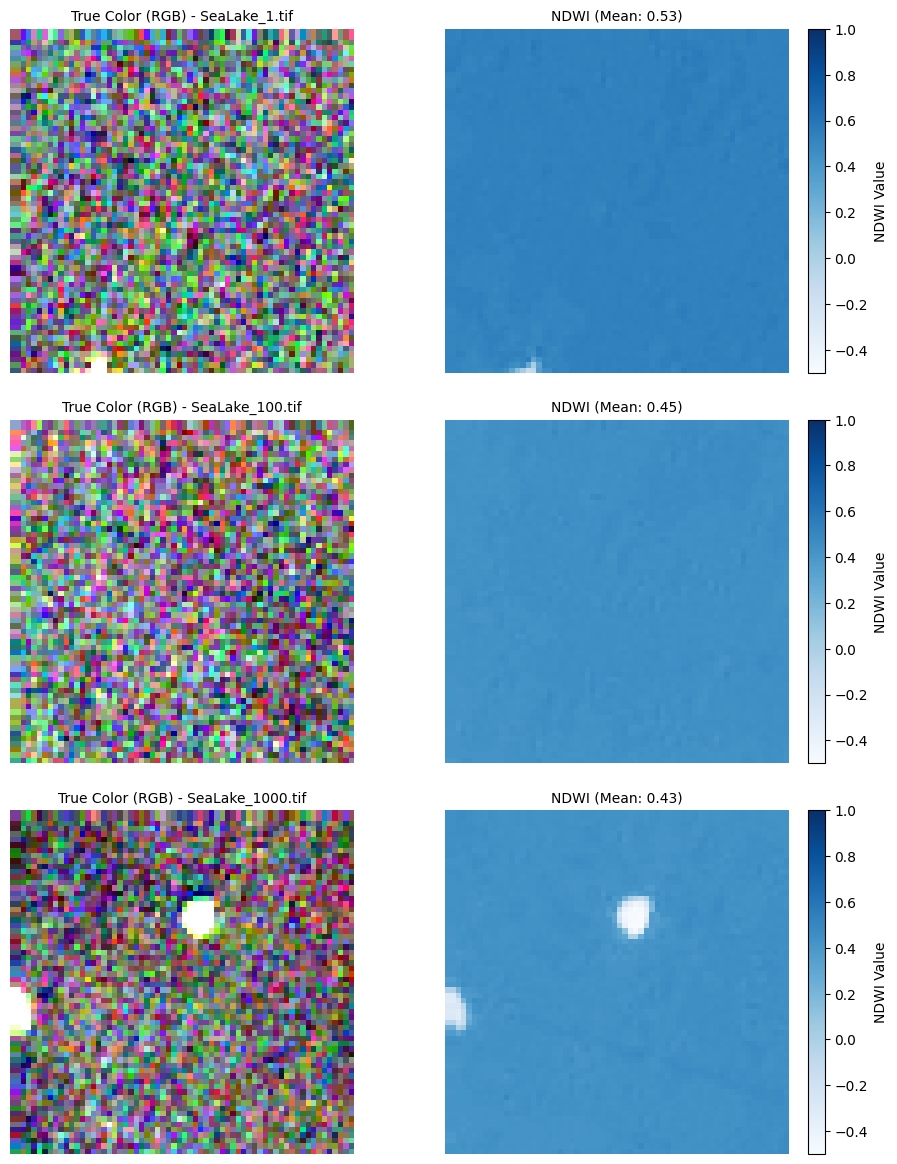

### 📊 Statistics for class: SeaLake

| File | Index | IndexMean | B1_mean | B2_mean | B3_mean | B4_mean | B5_mean | B6_mean | B7_mean | B8_mean | B9_mean | B10_mean | B11_mean | B12_mean | B13_mean |
|:--|:--|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|
| SeaLake_1.tif | NDWI | 0.5285 | 1042.9834 | 716.4238 | 440.4211 | 249.3982 | 213.9685 | 185.7717 | 168.3176 | 136.1157 | 67.5215 | 8.6450 | 29.8242 | 13.8389 | 119.7561 |
| SeaLake_100.tif | NDWI | 0.4471 | 1213.2830 | 818.7285 | 512.2095 | 311.5032 | 280.6467 | 260.3311 | 240.6897 | 195.7495 | 69.4167 | 7.8997 | 32.9487 | 15.6150 | 181.9148 |
| SeaLake_1000.tif | NDWI | 0.4263 | 1217.3757 | 822.6519 | 518.4915 | 319.9551 | 295.1140 | 280.7559 | 263.4126 | 218.9194 | 74.4995 | 7.1775 | 42.3108 | 21.4365 | 206.9753 |


✅ All sample images processed and displayed.


In [12]:
# ====== STEP 2.2: Display Sample Images from Each Class (Images first, then stats-only table) ======
from IPython.display import display, Markdown

# Loop through each class we found in Step 1
for CLASS_NAME in classes:
    class_dir = DATA_DIR / CLASS_NAME
    files = sorted(list(class_dir.glob("*.tif")))
    if not files:
        print(f"  ⚠️ No images found for class: {CLASS_NAME}")
        continue

    # Select up to 3 sample files to display
    sample_files = files[:3]

    # Get the best index (NDVI or NDWI) for this class
    index_name, cmap = get_relevant_index(CLASS_NAME)

    print(f"\n{'='*20} {CLASS_NAME} {'='*20}\n")

    # Create a plot figure. The size will adapt to the number of samples.
    fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 4 * len(sample_files)), squeeze=False)

    # Collect per-sample statistics for a single per-class table after plots
    summary_rows = []
    max_band_seen = 0  # track max band to build headers

    for i, sample_file in enumerate(sample_files):
        try:
            with rasterio.open(sample_file) as src:
                # Read all bands into a dictionary
                band_cache = {b: src.read(b) for b in range(1, src.count + 1)}
                max_band_seen = max(max_band_seen, src.count)

                # True Color composite (B4, B3, B2)
                rgb_composite = np.dstack([
                    enhanced_stretch(band_cache[4]),
                    enhanced_stretch(band_cache[3]),
                    enhanced_stretch(band_cache[2])
                ])

                # Relevant spectral index and mean (exclude zeros)
                index_map = calculate_index(band_cache, index_name)
                index_valid = index_map[index_map != 0]
                mean_index_value = float(np.nanmean(index_valid)) if index_valid.size else float("nan")

                # Plot RGB
                ax_rgb = axes[i, 0]
                ax_rgb.imshow(rgb_composite)
                ax_rgb.set_title(f'True Color (RGB) - {sample_file.name}', fontsize=10)
                ax_rgb.axis('off')

                # Plot index
                ax_idx = axes[i, 1]
                im = ax_idx.imshow(index_map, cmap=cmap, vmin=-0.5, vmax=1)
                ax_idx.set_title(f'{index_name} (Mean: {mean_index_value:.2f})', fontsize=10)
                ax_idx.axis('off')
                fig.colorbar(im, ax=ax_idx, fraction=0.046, pad=0.04, label=f'{index_name} Value')

                # Stats-only row: index mean + per-band mean (NoData-aware)
                row = {
                    "File": sample_file.name,
                    "Index": index_name,
                    "IndexMean": f"{mean_index_value:.4f}",
                }

                for b in range(1, src.count + 1):
                    arr = band_cache[b]
                    nodata_b = src.nodatavals[b - 1] if (src.nodatavals and len(src.nodatavals) >= b) else None
                    valid = arr[arr != nodata_b] if nodata_b is not None else arr[np.isfinite(arr)]
                    mean_b = float(np.nanmean(valid)) if valid.size else float("nan")
                    row[f"B{b}_mean"] = f"{mean_b:.4f}"
                summary_rows.append(row)

        except Exception as e:
            print(f"  ❌ Error processing image {sample_file.name}: {e}")

    # Show images first
    plt.tight_layout(pad=2.0)
    plt.show()

    # Build ONE stats-only Markdown table for this class
    if summary_rows:
        # Dynamic band headers based on maximum bands seen
        band_headers = [f"B{b}_mean" for b in range(1, max_band_seen + 1)]
        headers = ["File", "Index", "IndexMean"] + band_headers

        # Markdown header and alignment
        header_line = "| " + " | ".join(headers) + " |"
        align_line = "|" + "|".join([":--", ":--", "--:"] + ["--:"] * len(band_headers)) + "|"

        # Data lines
        data_lines = []
        for r in summary_rows:
            cells = [r.get(h, "-") for h in headers]
            data_lines.append("| " + " | ".join(cells) + " |")

        md_table = "\n".join([f"### 📊 Statistics for class: {CLASS_NAME}", "", header_line, align_line] + data_lines)
        display(Markdown(md_table))

print("\n✅ All sample images processed and displayed.")
print("=" * 65)

### 🎨 Figure: Example Image and Spectral Index for Each Land Cover Class
This is like having a photo album where each page shows two different ways to look at the same piece of land from space! For each type of land cover, we're showing you two views:

**Left Side (RGB True Color Images)**: These are the "normal" photos that look like what you'd see if you were looking down from a plane or drone. They show natural colors - green for healthy plants, blue for water, brown for soil, gray for buildings, etc. It's like looking at a regular photograph taken from hundreds of miles up in space!

**Right Side (Spectral Index Maps)**: These are special "filtered" views that highlight specific features:
- **Green/Yellow areas** in the index maps mean "lots of healthy plants" (high NDVI values)
- **Red/Brown areas** mean "few or no plants" (low NDVI values)
- **Blue areas** (for water classes) mean "definitely water" (high NDWI values)

By comparing these two views side by side, you can see how different each type of land looks:
- **Crop fields** show up as green rectangles in the RGB image and bright areas in the index
- **Forests** appear as dark green patches with very high vegetation index values
- **Water bodies** look blue in RGB and show up clearly in the water index
- **Cities and highways** appear gray in RGB and have low vegetation index values
- **Bare soil** shows up as brown/tan in RGB and has low index values

This comparison helps us understand why satellites can tell the difference between a forest and a parking lot, even from space!

## 📊 Step 3: Large-Scale Spectral Statistics

Now we move from looking at individual images to analyzing data in bulk. The goal here is to compute the **average spectral signature** for each land cover class.

A **spectral signature** is a plot showing how much light a material reflects at different wavelengths. For example, healthy vegetation reflects a lot of near-infrared light (which we can't see) and absorbs red light. This unique pattern is its signature.

To do this, we will:
1.  Take a large random sample of images from all classes.
2.  For each image, calculate the average pixel value (reflectance) for all 13 bands.
3.  Aggregate these statistics to find the overall mean reflectance per band for each class.
4.  Plot these signatures to compare them.

This process is computationally intensive, so we'll use **multi-threading** to speed it up significantly.

In [13]:
# ====== STEP 3.2: Parallel Processing of Images ======
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
import time

# --- Configuration ---
MAX_SAMPLES = 4000  # Max number of images to analyze. Increase for more precision, decrease for speed.
N_THREADS   = 8     # Number of parallel threads. Adjust based on your CPU cores.

# Get a list of all image files from all class directories
all_files = [f for c in classes for f in (DATA_DIR / c).glob("*.tif")]

# Select a random sample of files to process
if len(all_files) > MAX_SAMPLES:
    selected_files = random.sample(all_files, MAX_SAMPLES)
    print(f"📁 Analyzing a random sample of {len(selected_files):,} images (out of {len(all_files):,} total).")
else:
    selected_files = all_files
    print(f"📁 Analyzing all {len(selected_files):,} images.")

# --- Parallel Processing with ThreadPoolExecutor ---
results, errors = [], []
start_time = time.time()

# The 'with' statement ensures threads are properly closed
with ThreadPoolExecutor(max_workers=N_THREADS) as executor:
    # Submit all processing jobs to the thread pool
    futures = {executor.submit(process_image_for_stats, fp): fp for fp in selected_files}
    
    # Use tqdm to create a progress bar as jobs complete
    for future in tqdm(as_completed(futures), total=len(selected_files), desc="Processing Images"):
        res, err = future.result()
        if res: results.append(res)
        if err: errors.append(err)

end_time = time.time()
print(f"\n⏱️ Finished in {end_time - start_time:.2f} seconds.")
print(f"   - Successfully processed: {len(results):,}")
print(f"   - Encountered errors:   {len(errors):,}")

if errors:
    print("\nFirst 3 errors (if any):")
    for e in errors[:3]: print(f"  - {e}")

# --- Create a DataFrame from the results ---
if not results:
    raise ValueError("No images were processed successfully. Cannot continue analysis.")

df_stats = pd.DataFrame(results)
print("\n📄 First 5 rows of the resulting statistics DataFrame:")
display(df_stats.head())

📁 Analyzing a random sample of 4,000 images (out of 20,000 total).


Processing Images:   0%|          | 0/4000 [00:00<?, ?it/s]


⏱️ Finished in 64.33 seconds.
   - Successfully processed: 4,000
   - Encountered errors:   0

📄 First 5 rows of the resulting statistics DataFrame:


,filename,class,b01_mean,b01_std,b01_p05,b01_p95,b02_mean,b02_std,b02_p05,b02_p95,...,b11_p05,b11_p95,b12_mean,b12_std,b12_p05,b12_p95,b13_mean,b13_std,b13_p05,b13_p95
0,River_2269.tif,River,1632.010742,20.824986,1601.00,1673.00,1260.190430,75.953575,1163.00,1382.25,...,128.0,2724.00,776.641602,439.096558,83.00,1509.25,2032.040771,1119.256836,329.00,3812.50
1,Pasture_925.tif,Pasture,1082.563721,16.601954,1060.00,1107.00,847.335205,57.516911,788.00,964.00,...,1759.5,2449.25,881.744629,163.376831,698.75,1146.25,4633.406738,435.184509,3927.75,5411.00
2,PermanentCrop_582.tif,PermanentCrop,1404.890625,149.415741,1219.00,1729.25,1214.131348,347.963898,894.00,1800.00,...,1764.0,3900.00,1706.504883,692.633606,840.00,2913.00,3538.055664,483.375275,2908.75,4464.25
3,Industrial_1486.tif,Industrial,1619.309326,208.984039,1412.75,2074.50,1451.759521,423.255707,987.75,2451.00,...,1618.0,3069.25,1551.546143,301.433899,1172.75,2176.25,2150.683105,618.195801,1458.00,3069.50
4,Highway_1081.tif,Highway,1314.485352,78.832741,1232.00,1497.00,1004.684814,152.893250,838.00,1307.25,...,923.0,2485.25,973.932373,527.650024,413.75,2083.25,2712.178711,685.892883,1802.00,3969.25


### Cross-Class Summary and Heatmap

With the statistics from all the sampled images, we can now aggregate the results. We'll group the data by class and calculate the average `mean` reflectance for each band. 

A **heatmap** is a perfect way to visualize this summary table. It uses color intensity to represent values, making it very easy to spot patterns, such as which bands are brightest or dimmest for each land cover type.


📋 Cross-Class Mean Reflectance Summary Table:


,B01-Coastal,B02-Blue,B03-Green,B04-Red,B05-RedEdge1,B06-RedEdge2,B07-RedEdge3,B08-NIR,B09-WaterVapor,B10-Cirrus,B11-SWIR1,B12-SWIR2,B13-NIRNarrow
class,,,,,,,,,,,,,
AnnualCrop,1413.0,1254.9,1285.6,1397.7,1687.0,2664.9,3190.6,3087.5,849.8,13.6,2656.5,1689.4,3530.8
Forest,1107.5,807.5,678.2,410.2,732.1,2080.3,2676.5,2623.6,827.3,9.9,1299.6,529.2,2994.3
HerbaceousVegetation,1329.5,1116.8,1054.7,1048.1,1359.2,2046.0,2342.6,2351.3,1044.7,16.4,2337.8,1435.8,2634.5
Highway,1339.8,1096.5,1022.9,923.2,1211.4,2170.0,2592.6,2516.9,806.6,12.2,1910.3,1152.6,2846.6
Industrial,1669.4,1467.7,1371.8,1364.9,1510.8,2006.8,2244.0,2126.8,638.8,12.1,2051.9,1496.9,2388.3
Pasture,1293.2,1006.5,945.2,653.7,1170.2,2805.2,3466.7,3406.8,1106.5,13.0,1962.4,942.7,3858.0
PermanentCrop,1422.0,1232.5,1250.9,1326.0,1608.2,2438.6,2844.3,2755.6,810.2,13.6,2692.4,1758.8,3130.7
Residential,1458.6,1214.1,1115.2,1081.2,1292.8,1982.1,2289.0,2186.3,658.8,12.4,1995.9,1402.9,2471.6
River,1309.3,1039.3,921.1,713.4,922.7,1672.8,2010.2,1933.4,593.7,10.5,1294.4,726.3,2179.2


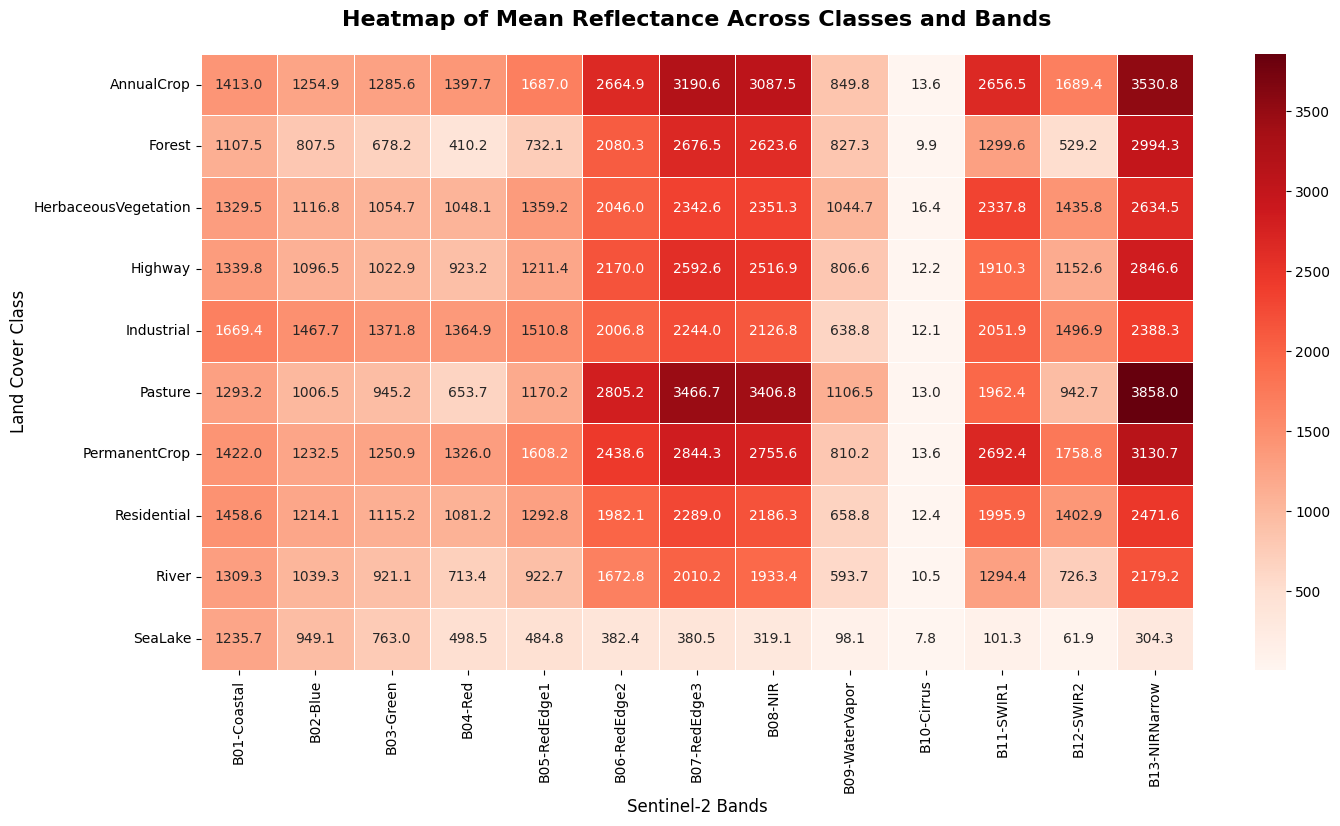

In [19]:
# ====== STEP 3.3: Aggregate Results and Create Summary ======

# Use pivot_table to group by class and calculate the mean of the 'mean' columns for each band
mean_columns = [f'b{b:02d}_mean' for b in range(1, 14)]
summary_df = df_stats.pivot_table(
    index='class',
    values=mean_columns,
    aggfunc='mean'
)

# Optional: Add band names to the columns for better readability
summary_df.columns = [f"B{i:02d}-{SENTINEL2_BANDS[i]['name'].split('-')[1]}" for i in range(1, 14)]


print("\n📋 Cross-Class Mean Reflectance Summary Table:")
display(summary_df.style.background_gradient(cmap='viridis').format("{:.1f}"))

# --- Visualize the Summary as a Heatmap ---
plt.figure(figsize=(16, 8))
sns.heatmap(
    summary_df,
    annot=True,       # Show the numerical values in each cell
    fmt=".1f",        # Format numbers to one decimal place
    cmap='Reds',     # Use a visually appealing color map
    linewidths=.5     # Add lines between cells
)
plt.title('Heatmap of Mean Reflectance Across Classes and Bands', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sentinel-2 Bands', fontsize=12)
plt.ylabel('Land Cover Class', fontsize=12)
plt.show()

### 📈 Figure: Spectral Signatures - The "Fingerprints" of Different Land Types
This colorful line graph shows us the unique "spectral fingerprints" of each type of land! Think of it like each land type having its own special signature that tells us what it is, even from space.

Each colored line represents a different type of land (forest, water, city, etc.), and the line shows us how much light that land type reflects at 13 different wavelengths (colors of light). It's like asking each land type: "What colors of light do you like to bounce back to the satellite?"

Here's what to look for in these "fingerprints":

**🌲 Vegetation Classes (Forest, Crops, Pasture)**: These lines have a special pattern:
- They dip down in the red area (around B04) - plants absorb red light for photosynthesis
- They shoot way up in the near-infrared area (around B08) - healthy plants reflect lots of near-infrared light
- This creates a "red edge" pattern that's like a signature saying "I'm a healthy plant!"

**💧 Water Classes (River, SeaLake)**: These lines stay very low across most wavelengths:
- Water absorbs most light, so these lines are mostly flat and low
- It's like water is saying "I don't reflect much light back to you"

**🏗️ Urban Classes (Highway, Industrial, Residential)**: These lines are more steady:
- They reflect light more evenly across different wavelengths
- No big dips or peaks - just a steady pattern
- It's like concrete and buildings saying "I reflect light pretty evenly"

**🏔️ Bare Soil/Herbaceous**: These lines are in between:
- Higher than water, but lower than healthy vegetation in the near-infrared
- More even than vegetation across the spectrum

This graph is super powerful because it shows us exactly why satellites can tell the difference between a healthy forest and a parking lot - they have completely different spectral fingerprints!

### Plotting the Spectral Signatures

Finally, let's plot the data from our summary table as a line graph. Each line on the graph will represent a land cover class, and the x-axis will show the 13 Sentinel-2 bands. This graph is the classic way to view and compare **spectral signatures**.

#### 💡 What to look for:
- **Vegetation Classes**: Look for a dip in the Red (B04) region and a sharp rise in the Near-Infrared (B08). This is the "red edge," a classic sign of healthy vegetation.
- **Water Classes**: Water absorbs most light, so expect these classes to have very low reflectance across almost all bands.
- **Urban/Bare Soil Classes**: These tend to have higher reflectance than vegetation in the visible spectrum and lack the sharp NIR peak.

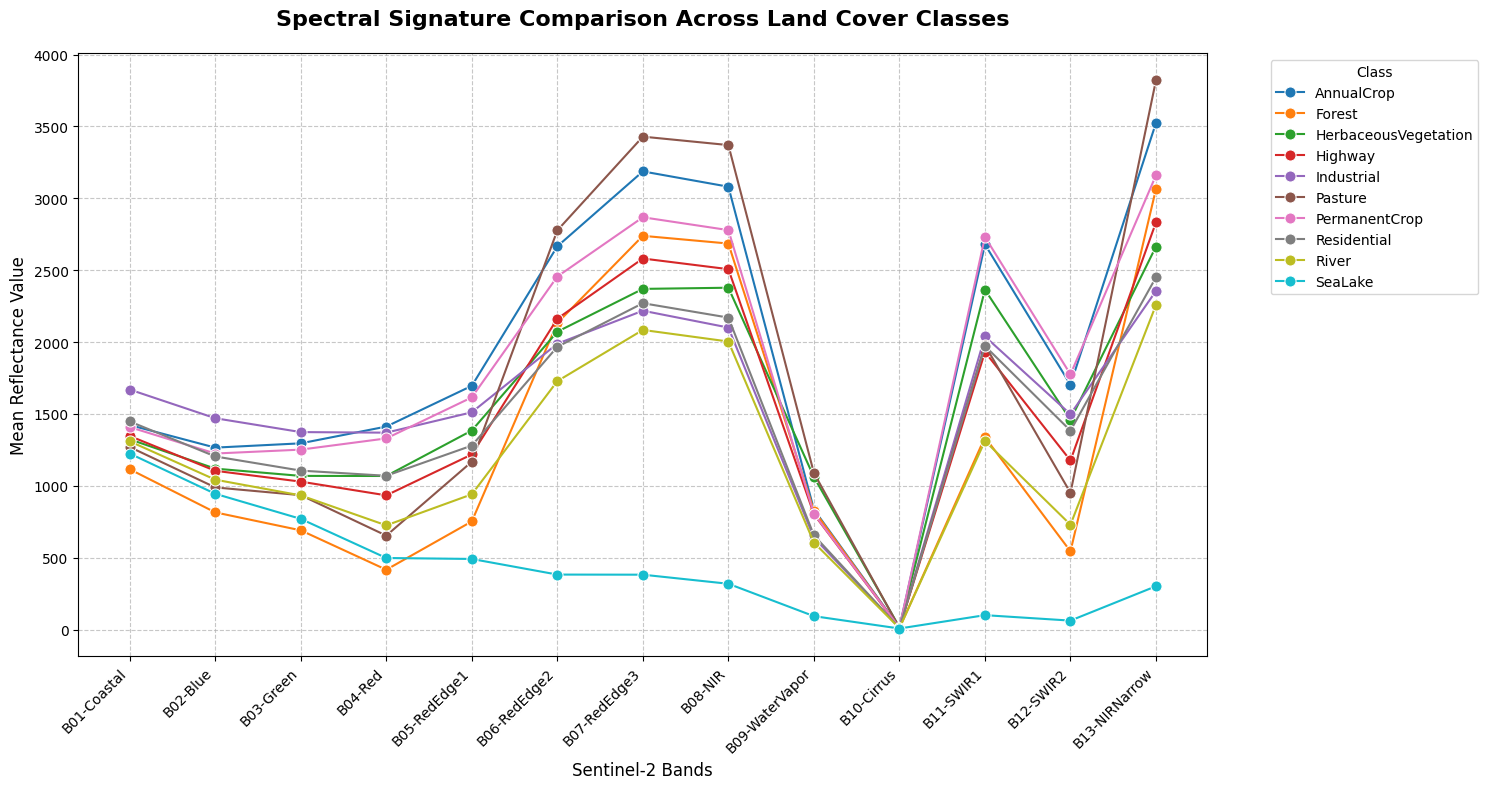

In [7]:
# ====== STEP 3.4: Plotting Spectral Signatures ======

plt.figure(figsize=(15, 8))

# Transpose the DataFrame so that bands are on the x-axis and plot each class as a line
ax = sns.lineplot(data=summary_df.T, palette="tab10", dashes=False, marker='o', markersize=8)

# --- Formatting the Plot ---
plt.title('Spectral Signature Comparison Across Land Cover Classes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sentinel-2 Bands', fontsize=12)
plt.ylabel('Mean Reflectance Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Move the legend outside the plot area for better visibility
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout() # Ensure all elements fit without overlapping
plt.show()

### 🔥 Figure: Spectral Signature Heatmap - The "Thermal Camera" View
This colorful grid is like looking at the spectral signatures through a thermal camera! Each row represents a different type of land, and each column represents a different type of light (Sentinel-2 band). The colors tell us how much light each land type reflects.

**How to read this heatmap:**
- **Bright colors (yellow, white)**: "I reflect lots of this type of light!"
- **Dark colors (purple, black)**: "I don't reflect much of this type of light"
- **Medium colors (green, blue)**: "I reflect some of this type of light"

**What patterns can you spot?**

**🌲 Vegetation Rows (Forest, AnnualCrop, etc.)**: Look for the "vegetation signature":
- Dark spots in the red bands (B04) - plants absorb red light
- Bright spots in the near-infrared bands (B08, B8A) - plants reflect lots of near-infrared light
- This creates a distinctive "dark-bright" pattern that screams "I'm a plant!"

**💧 Water Rows (River, SeaLake)**: Look for the "water signature":
- Mostly dark colors across most bands - water absorbs most light
- Only a few brighter spots in specific bands
- This creates a "mostly dark" pattern that says "I'm water!"

**🏗️ Urban Rows (Highway, Industrial, Residential)**: Look for the "city signature":
- More even, medium-bright colors across most bands
- No dramatic dark spots or super bright spots
- This creates a "steady" pattern that says "I'm built by humans!"

**🎯 Why this heatmap is amazing:**
It's like having a cheat sheet that shows exactly which types of light are most useful for telling different land types apart. Scientists and computers can use this to build better tools for mapping land use from space!

## 🏁 Conclusion & Key Takeaways

This notebook has provided a thorough overview of the EuroSAT multispectral dataset. We have successfully:

1.  **Validated and Profiled the Dataset**: We confirmed the structure and understood the distribution of images across 10 distinct land cover classes.

2.  **Visually Inspected Samples**: By comparing True Color images with spectral indices like NDVI and NDWI, we saw firsthand how different band calculations can highlight specific features like vegetation and water.

3.  **Quantified Spectral Signatures**: Through large-scale parallel processing, we computed the mean reflectance for each class across all 13 Sentinel-2 bands. 

The final **heatmap and spectral signature plot** clearly demonstrate that each land cover class has a distinct spectral fingerprint. These unique signatures are precisely what allows machine learning models to differentiate between a forest, a river, and a highway from space.

This foundational analysis is the first step toward building powerful land cover classification models.

In [17]:
# ====== STEP 3.2: Parallel Processing (20,000 samples, compact ML features, CSV, label last) ======
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
import time, random
import pandas as pd
import numpy as np

# --- Configuration ---
MAX_SAMPLES = 20000                 # analyze up to 20k images
N_THREADS   = 8                     # tune for your CPU
OUTPUT_CSV  = "eurosat_ml_compact.csv"

# Compact feature set for ML (keep only important bands and stats)
# Bands: B02 (Blue), B03 (Green), B04 (Red), B08 (NIR), B11 (SWIR1), B12 (SWIR2)
# Stats: mean + std only (drop p05/p95)
feature_bands = [2, 3, 4, 8, 11, 12 , 13]
stats_keep    = ["mean", "std"]

# Build desired feature column names e.g., ['b02_mean','b02_std', ...]
desired_feature_cols = [f"b{b:02d}_{s}" for b in feature_bands for s in stats_keep]

# Get a list of all image files from all class directories
all_files = [f for c in classes for f in (DATA_DIR / c).glob("*.tif")]

# Sample up to MAX_SAMPLES
if len(all_files) > MAX_SAMPLES:
    selected_files = random.sample(all_files, MAX_SAMPLES)
    print(f"📁 Analyzing a random sample of {len(selected_files):,} images (out of {len(all_files):,} total).")
else:
    selected_files = all_files
    print(f"📁 Analyzing all {len(selected_files):,} images.")

# --- Parallel Processing ---
results, errors = [], []
start_time = time.time()

with ThreadPoolExecutor(max_workers=N_THREADS) as executor:
    futures = {executor.submit(process_image_for_stats, fp): fp for fp in selected_files}
    for future in tqdm(as_completed(futures), total=len(selected_files), desc="Processing Images"):
        res, err = future.result()
        if res: results.append(res)
        if err: errors.append(err)

end_time = time.time()
print(f"\n⏱️ Finished in {end_time - start_time:.2f} seconds.")
print(f"   - Successfully processed: {len(results):,}")
print(f"   - Encountered errors:   {len(errors):,}")

if errors:
    print("\nFirst 3 errors (if any):")
    for e in errors[:3]:
        print(f"  - {e}")

# --- Build compact ML dataset ---
if not results:
    raise ValueError("No images were processed successfully. Cannot continue analysis.")

df = pd.DataFrame(results)

# Drop filename if present
if "filename" in df.columns:
    df = df.drop(columns=["filename"])

# Ensure class exists
if "class" not in df.columns:
    raise KeyError("Expected 'class' column missing in results from process_image_for_stats().")

# Keep ONLY desired features + class label
existing_feats = [c for c in desired_feature_cols if c in df.columns]
missing_feats  = sorted(set(desired_feature_cols) - set(existing_feats))
if missing_feats:
    print(f"⚠️ Missing expected feature columns (will be filled with NaN): {', '.join(missing_feats)}")
    for m in missing_feats:
        df[m] = np.nan

# Reorder: features first (in our compact list order), label last
df_ml = df[desired_feature_cols + ["class"]]

print("\n📄 First 5 rows (compact features, label last):")
display(df_ml.head())

# --- Save CSV ---
df_ml.to_csv(OUTPUT_CSV, index=False)
print(f"\n💾 Saved ML dataset to: {OUTPUT_CSV}")
print(f"   Columns: {len(df_ml.columns)} (features: {len(desired_feature_cols)}, label: 1)")
print(f"   Rows: {len(df_ml):,}")

📁 Analyzing all 20,000 images.


Processing Images:   0%|          | 0/20000 [00:00<?, ?it/s]


⏱️ Finished in 654.50 seconds.
   - Successfully processed: 20,000
   - Encountered errors:   0

📄 First 5 rows (compact features, label last):


,b02_mean,b02_std,b03_mean,b03_std,b04_mean,b04_std,b08_mean,b08_std,b11_mean,b11_std,b12_mean,b12_std,b13_mean,b13_std,class
0,1239.827881,112.036949,1227.600586,189.264038,1479.285889,344.363647,2243.432129,678.439880,3163.708008,467.012726,2206.157227,266.476990,2664.482422,776.399719,AnnualCrop
1,1124.514648,69.507568,1044.731934,98.271431,1169.281494,173.940887,1748.955322,396.474792,2715.398682,257.534576,1980.885010,257.585480,2030.545166,435.588745,AnnualCrop
2,1543.559082,179.137466,1612.584961,190.106567,1922.695312,415.337463,2893.610352,433.165710,3569.552490,590.316956,2664.005127,594.045044,3337.251221,438.829865,AnnualCrop
3,1326.116455,405.111145,1394.580566,497.250031,1606.433594,728.796265,2994.235840,825.899597,2818.968018,653.354065,1682.419434,542.777283,3481.285889,883.044739,AnnualCrop
4,1077.404297,93.262543,1057.242432,108.158646,779.681396,210.283920,3560.333008,689.373108,2281.889893,184.268250,1188.897217,245.780319,4053.922363,698.376221,AnnualCrop



💾 Saved ML dataset to: eurosat_ml_compact.csv
   Columns: 15 (features: 14, label: 1)
   Rows: 20,000


In [ ]:
# =============================================
# LAND TYPE CLASSIFICATION (SENTINEL-2)
# Enhanced Pipeline with 5 Top Models & Visualizations
# =============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("=" * 70)
print("🛰️  SENTINEL-2 LAND TYPE CLASSIFICATION PIPELINE")
print("=" * 70)

# ============================================================================
# 1️⃣ LOAD AND EXPLORE DATASET
# ============================================================================
print("\n📂 Loading dataset...")
df = pd.read_csv("eurosat_ml_compact.csv")

print(f"\n✅ Dataset loaded successfully!")
print(f"   • Total samples: {len(df):,}")
print(f"   • Total features: {len(df.columns) - 1}")
print(f"   • Classes: {df['class'].nunique()}")
print(f"\n📊 Class Distribution:")
print(df['class'].value_counts().to_string())

# ============================================================================
# 2️⃣ DATA PREPARATION
# ============================================================================
print("\n🔧 Preparing data...")

X = df.drop("class", axis=1)
y = df["class"]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split: 60% Train / 20% Validation / 20% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"   • Training set: {len(X_train):,} samples")
print(f"   • Validation set: {len(X_valid):,} samples")
print(f"   • Test set: {len(X_test):,} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("   ✅ Data scaling completed")

# ============================================================================
# 3️⃣ DEFINE 5 BEST MODELS
# ============================================================================
print("\n🤖 Initializing 5 top-performing models...")

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, 
        max_depth=20,
        min_samples_split=5,
        random_state=42, 
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        depth=8,
        learning_rate=0.1,
        verbose=0,
        random_seed=42
    ),
    "SVM (RBF)": SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        random_state=42,
        probability=True
    )
}

# ============================================================================
# 4️⃣ TRAIN & EVALUATE ALL MODELS
# ============================================================================
print("\n" + "=" * 70)
print("🚀 TRAINING MODELS")
print("=" * 70)

results = []
trained_models = {}

for name, model in models.items():
    print(f"\n⏳ Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Predictions
    train_preds = model.predict(X_train_scaled)
    valid_preds = model.predict(X_valid_scaled)
    
    # Metrics
    train_acc = accuracy_score(y_train, train_preds)
    valid_acc = accuracy_score(y_valid, valid_preds)
    precision = precision_score(y_valid, valid_preds, average='weighted', zero_division=0)
    recall = recall_score(y_valid, valid_preds, average='weighted')
    f1 = f1_score(y_valid, valid_preds, average='weighted')
    
    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Valid Accuracy": valid_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })
    
    print(f"   ✅ {name} trained successfully!")
    print(f"      • Train Accuracy: {train_acc:.4f}")
    print(f"      • Valid Accuracy: {valid_acc:.4f}")
    print(f"      • F1-Score: {f1:.4f}")

# ============================================================================
# 5️⃣ RESULTS COMPARISON
# ============================================================================
results_df = pd.DataFrame(results).sort_values(by="Valid Accuracy", ascending=False)

print("\n" + "=" * 70)
print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 70)
print(results_df.to_string(index=False))

# ============================================================================
# 6️⃣ VISUALIZATIONS
# ============================================================================
print("\n📈 Generating visualizations...")

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# 1. Model Accuracy Comparison
ax1 = plt.subplot(2, 3, 1)
models_sorted = results_df.sort_values('Valid Accuracy')
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(models_sorted)))
bars = ax1.barh(models_sorted['Model'], models_sorted['Valid Accuracy'], color=colors)
ax1.set_xlabel('Validation Accuracy', fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontweight='bold', fontsize=12)
ax1.set_xlim([0.8, 1.0])
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontweight='bold')

# 2. All Metrics Comparison (Grouped Bar Chart)
ax2 = plt.subplot(2, 3, 2)
metrics = ['Valid Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2
for i, metric in enumerate(metrics):
    ax2.bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)
ax2.set_xlabel('Models', fontweight='bold')
ax2.set_ylabel('Score', fontweight='bold')
ax2.set_title('All Metrics Comparison', fontweight='bold', fontsize=12)
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.legend(loc='lower right')
ax2.set_ylim([0.8, 1.0])
ax2.grid(axis='y', alpha=0.3)

# 3. Train vs Validation Accuracy
ax3 = plt.subplot(2, 3, 3)
x_pos = np.arange(len(results_df))
width = 0.35
ax3.bar(x_pos - width/2, results_df['Train Accuracy'], width, label='Train', alpha=0.8, color='skyblue')
ax3.bar(x_pos + width/2, results_df['Valid Accuracy'], width, label='Validation', alpha=0.8, color='coral')
ax3.set_xlabel('Models', fontweight='bold')
ax3.set_ylabel('Accuracy', fontweight='bold')
ax3.set_title('Train vs Validation Accuracy', fontweight='bold', fontsize=12)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax3.legend()
ax3.set_ylim([0.8, 1.0])
ax3.grid(axis='y', alpha=0.3)

# 4. F1-Score Ranking
ax4 = plt.subplot(2, 3, 4)
models_f1 = results_df.sort_values('F1-Score')
colors_f1 = plt.cm.plasma(np.linspace(0.3, 0.9, len(models_f1)))
bars_f1 = ax4.barh(models_f1['Model'], models_f1['F1-Score'], color=colors_f1)
ax4.set_xlabel('F1-Score', fontweight='bold')
ax4.set_title('F1-Score Ranking', fontweight='bold', fontsize=12)
ax4.set_xlim([0.8, 1.0])
for i, bar in enumerate(bars_f1):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontweight='bold')

# 5. Confusion Matrix for Best Model
best_model_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]
valid_preds = best_model.predict(X_valid_scaled)
cm = confusion_matrix(y_valid, valid_preds)

ax5 = plt.subplot(2, 3, 5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax5, 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, cbar_kws={'label': 'Count'})
ax5.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
ax5.set_ylabel('True Label', fontweight='bold')
ax5.set_xlabel('Predicted Label', fontweight='bold')

# 6. Class Distribution
ax6 = plt.subplot(2, 3, 6)
class_counts = df['class'].value_counts()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
wedges, texts, autotexts = ax6.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax6.set_title('Class Distribution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('model_comparison_results.png', dpi=300, bbox_inches='tight')
print("   ✅ Visualization saved as 'model_comparison_results.png'")
plt.show()

# ============================================================================
# 7️⃣ TEST BEST MODEL
# ============================================================================
print("\n" + "=" * 70)
print(f"🏆 TESTING BEST MODEL: {best_model_name}")
print("=" * 70)

test_preds = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds, average='weighted')

print(f"\n📊 Test Set Performance:")
print(f"   • Accuracy: {test_acc:.4f}")
print(f"   • F1-Score: {test_f1:.4f}")

print(f"\n📋 Detailed Classification Report:\n")
print(classification_report(y_test, test_preds, target_names=label_encoder.classes_))

# Test Set Confusion Matrix
plt.figure(figsize=(10, 8))
cm_test = confusion_matrix(y_test, test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Test Set Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig('test_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n   ✅ Test confusion matrix saved as 'test_confusion_matrix.png'")
plt.show()

# ============================================================================
# 8️⃣ SAVE MODELS AND ARTIFACTS
# ============================================================================
print("\n💾 Saving models and artifacts...")

joblib.dump(best_model, f"{best_model_name.replace(' ', '_')}_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

# Save results to CSV
results_df.to_csv("model_comparison_results.csv", index=False)

print(f"   ✅ Best model saved as '{best_model_name.replace(' ', '_')}_model.pkl'")
print("   ✅ Scaler saved as 'scaler.pkl'")
print("   ✅ Label encoder saved as 'label_encoder.pkl'")
print("   ✅ Results saved as 'model_comparison_results.csv'")

# ============================================================================
# 9️⃣ FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("✨ PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 70)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Validation Accuracy: {results_df.iloc[0]['Valid Accuracy']:.4f}")
print(f"   • Test Accuracy: {test_acc:.4f}")
print(f"   • F1-Score: {test_f1:.4f}")
print("\n📁 Generated Files:")
print("   • model_comparison_results.png")
print("   • test_confusion_matrix.png")
print("   • model_comparison_results.csv")
print(f"   • {best_model_name.replace(' ', '_')}_model.pkl")
print("   • scaler.pkl")
print("   • label_encoder.pkl")
print("\n" + "=" * 70)

🛰️  SENTINEL-2 LAND TYPE CLASSIFICATION PIPELINE

📂 Loading dataset...

✅ Dataset loaded successfully!
   • Total samples: 20,000
   • Total features: 14
   • Classes: 10

📊 Class Distribution:
class
AnnualCrop              2000
Forest                  2000
HerbaceousVegetation    2000
Highway                 2000
Industrial              2000
Pasture                 2000
PermanentCrop           2000
Residential             2000
River                   2000
SeaLake                 2000

🔧 Preparing data...
   • Training set: 12,000 samples
   • Validation set: 4,000 samples
   • Test set: 4,000 samples
   ✅ Data scaling completed

🤖 Initializing 5 top-performing models...

🚀 TRAINING MODELS

⏳ Training Random Forest...
   ✅ Random Forest trained successfully!
      • Train Accuracy: 0.9896
      • Valid Accuracy: 0.8475
      • F1-Score: 0.8457

⏳ Training XGBoost...
   ✅ XGBoost trained successfully!
      • Train Accuracy: 1.0000
      • Valid Accuracy: 0.8788
      • F1-Score: 0.8782

KeyboardInterrupt: 